In [1]:
# # check GPU
!nvidia-smi

Fri Jan 13 15:15:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# # pulls repo to colab
!git clone https://github.com/char-tan/mode_connectivity.git

# # checkout specific branch if needed
!cd mode_connectivity; git checkout super_model

Cloning into 'mode_connectivity'...
remote: Enumerating objects: 783, done.
remote: Counting objects: 100% (398/398), done.
remote: Compressing objects: 100% (218/218), done.
remote: Total 783 (delta 208), reused 321 (delta 179), pack-reused 385
Receiving objects: 100% (783/783), 37.55 MiB | 16.70 MiB/s, done.
Resolving deltas: 100% (452/452), done.
Branch 'super_model' set up to track remote branch 'super_model' from 'origin'.
Switched to a new branch 'super_model'


In [3]:
# allows you to change the .py files and have the imports updated
%load_ext autoreload
%autoreload 2

In [4]:
import sys, os
SCRIPT_DIR = os.path.dirname(os.path.abspath('.'))
sys.path.append(os.path.dirname(SCRIPT_DIR))

sys.path.append("mode_connectivity")

In [5]:
import torch
from torchvision import transforms, datasets
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from mode_connectivity.utils import weight_matching, data, training_utils, plot, utils
from mode_connectivity.training_config import *
from mode_connectivity.lmc import *
from mode_connectivity.training import *

from mode_connectivity.models.mlp import MLP

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Training MLP models

In [7]:
training_config = MLP_MNIST_DEFAULT
training_config.epochs = 5
training_config.seed = 7

# train model a
# model_a_noisy = train_model(*setup_train(training_config, additional_train_transforms = [AddGaussianNoise(0., 0.1)]), verbose = 1)
model_a = train_model(*setup_train(training_config), verbose = 1)
torch.save(model_a.state_dict(), 'mlp_mnist_model_a.pt')

# change seed to get different model
training_config.seed = 42

# train model b
# model_b_noisy = train_model(*setup_train(training_config, additional_train_transforms = [AddGaussianNoise(0., 0.1)]), verbose = 1)
model_b = train_model(*setup_train(training_config), verbose = 1)
torch.save(model_b.state_dict(), 'mlp_mnist_model_b.pt')  

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Train Epoch: 1, Train Accuracy: (90%) 
Average loss: 0.1301, Accuracy: (96%)
Train Epoch: 2, Train Accuracy: (97%) 
Average loss: 0.0942, Accuracy: (97%)
Train Epoch: 3, Train Accuracy: (98%) 
Average loss: 0.0708, Accuracy: (98%)
Train Epoch: 4, Train Accuracy: (99%) 
Average loss: 0.0864, Accuracy: (97%)
Train Epoch: 5, Train Accuracy: (99%) 
Average loss: 0.0811, Accuracy: (97%)
Train Epoch: 1, Train Accuracy: (90%) 
Average loss: 0.1392, Accuracy: (96%)
Train Epoch: 2, Train Accuracy: (97%) 
Average loss: 0.0911, Accuracy: (97%)
Train Epoch: 3, Train Accuracy: (98%) 
Average loss: 0.0784, Accuracy: (98%)
Train Epoch: 4, Train Accuracy: (98%) 
Average loss: 0.0707, Accuracy: (98%)
Train Epoch: 5, Train Accuracy: (99%) 
Average loss: 0.0840, Accuracy: (98%)


# LMC in param space

In [9]:
n_points = 5
(
    permuted_params,
    train_acc_naive,
    test_acc_naive,
    train_acc_perm,
    test_acc_perm,
) = linear_mode_connect(
    MLP, "mlp_mnist_model_a.pt", "mlp_mnist_model_b.pt", "mnist", n_points=n_points, verbose=1
)
torch.save(permuted_params, 'mlp_mnist_model_pb.pt') 


performing naive interpolation
Average loss: 0.0334, Accuracy: (99%)
Average loss: 0.0811, Accuracy: (97%)
Average loss: 0.2660, Accuracy: (98%)
Average loss: 0.2797, Accuracy: (97%)
Average loss: 1.3403, Accuracy: (91%)
Average loss: 1.3384, Accuracy: (90%)
Average loss: 0.2538, Accuracy: (98%)
Average loss: 0.2732, Accuracy: (97%)
Average loss: 0.0343, Accuracy: (99%)
Average loss: 0.0840, Accuracy: (98%)
point 5/5. 
permuting model

performing permuted interpolation
Average loss: 0.0334, Accuracy: (99%)
Average loss: 0.0811, Accuracy: (97%)
Average loss: 0.0399, Accuracy: (99%)
Average loss: 0.0732, Accuracy: (98%)
Average loss: 0.0480, Accuracy: (99%)
Average loss: 0.0773, Accuracy: (98%)
Average loss: 0.0394, Accuracy: (99%)
Average loss: 0.0763, Accuracy: (98%)
Average loss: 0.0343, Accuracy: (99%)
Average loss: 0.0840, Accuracy: (98%)


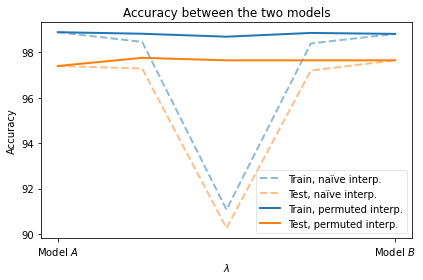

In [10]:
# First we do the basic linear interpolation plot
lambdas = torch.linspace(0, 1, steps=n_points)
fig = plot.plot_interp_metric("accuracy", lambdas, train_acc_naive, test_acc_naive, train_acc_perm, test_acc_perm)

# Geodesic MC in functional space

In [12]:
from mode_connectivity.geodesic_opt import optimise_for_geodesic, metric_path_length

In [13]:
# load in model state_dicts
model_file_path = 'mode_connectivity/model_files/' # use this path in colab
# model_file_path = '../model_files/'

# model_a, model_b, model_pb = (MLP(), MLP(), MLP())
# utils.load_checkpoint(model_a, model_file_path + "mlp_mnist_model_a.pt", device)
# utils.load_checkpoint(model_b, model_file_path + "mlp_mnist_model_b.pt", device)
# utils.load_checkpoint(model_pb, model_file_path + "mlp_mnist_model_pb.pt", device)

weights_a = torch.load(model_file_path + "mlp_mnist_model_a.pt", map_location=device)
weights_b = torch.load(model_file_path + "mlp_mnist_model_b.pt", map_location=device)
weights_pb = torch.load(model_file_path + "mlp_mnist_model_pb.pt", map_location=device)

In [14]:
train_kwargs = {"batch_size":128, 'num_workers': 0, 'pin_memory': False}
test_kwargs = {"batch_size":512, 'num_workers': 0, 'pin_memory': False}

train_loader, test_loader = data.get_data_loaders(
    dataset="mnist", train_kwargs=train_kwargs, test_kwargs=test_kwargs
)

In [48]:
from super import SuperModel

N = 10

super_model = SuperModel(MLP, N, weights_a, weights_pb).to(device)

path_lengths, sq_euc_dists, path_accs  = optimise_for_geodesic(
        super_model,
        train_loader,
        lr = 1e-3,
    )

Optimising geodesic ...
batch 0 | path length 0.004163017962127924 | sq euc dist 138.67153930664062 | mean path acc 98.59375
batch 1 | path length 0.005629508290439844 | sq euc dist 138.67153930664062 | mean path acc 98.515625
batch 2 | path length 0.0015897097764536738 | sq euc dist 138.67153930664062 | mean path acc 100.0
batch 3 | path length 0.0037320228293538094 | sq euc dist 138.67152404785156 | mean path acc 97.578125
batch 4 | path length 0.00430351123213768 | sq euc dist 138.67152404785156 | mean path acc 99.0625
batch 5 | path length 0.0033467523753643036 | sq euc dist 138.67153930664062 | mean path acc 99.453125
batch 6 | path length 0.0027581246104091406 | sq euc dist 138.67153930664062 | mean path acc 99.21875
batch 7 | path length 0.005047701299190521 | sq euc dist 138.67153930664062 | mean path acc 98.671875
batch 8 | path length 0.006753843743354082 | sq euc dist 138.67153930664062 | mean path acc 98.28125
batch 9 | path length 0.005466898903250694 | sq euc dist 138.671


# I ONLY WORKED UP TO HERE (CHARLIE)

In [ ]:
loss_plots = [loss.detach().cpu() for loss in losses]
sq_euclid_dist_plots = [euclid_dist.detach().cpu() for euclid_dist in euclid_dists]

In [ ]:
fig, ax = plt.subplots()

loss_type = 'JSD loss'

ax.plot(loss_plots, color = 'red')
ax.set_xlabel('GD iteration', fontsize = 14)
ax.set_ylabel('path action via ' + loss_type, color = 'red', fontsize = 14)

ax2=ax.twinx()
ax2.plot(sq_euclid_dist_plots, color = 'blue')
ax2.set_ylabel('path action via (squared) euclid dist', color = 'blue', fontsize = 14)

In [49]:
!cd mode_connectivity && git status

On branch super_model
Your branch is up to date with 'origin/super_model'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   geodesic_opt.py
	modified:   lmc.py
	modified:   utils/metrics.py

no changes added to commit (use "git add" and/or "git commit -a")
